In [75]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
from sklearn import preprocessing, neighbors, svm
from sklearn.ensemble import RandomForestClassifier, VotingClassifier,AdaBoostClassifier,GradientBoostingClassifier, BaggingClassifier
from sklearn.cluster import KMeans
from scipy.stats import mode
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
import csv as csv
from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split, KFold

from sklearn.metrics import classification_report
from sklearn.model_selection import learning_curve

import matplotlib.pyplot as plt
from matplotlib import style
style.use('ggplot')
%matplotlib inline
# import warnings, random
# from collections import Counter
# from math import sqrt

In [2]:
df = pd.read_csv('data/train.csv')
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
def handle_non_numerical_data(df): 
    columns = df.columns.values
    for column in columns:
        text_digit_vals = {}
        def convert_to_int(val):
            return text_digit_vals[val]

        if df[column].dtype != np.int64 and df[column].dtype != np.float64:
            column_contents = df[column].values.tolist()
            unique_elements = set(column_contents)

            x = 0
            for unique in unique_elements:
                if unique not in text_digit_vals:
                    text_digit_vals[unique] = x
                    x += 1

            df[column] = list(map(convert_to_int,df[column] ))
    
    return df

In [4]:
# Deal with empty

# All missing Embarked -> just make them embark from most common place
if len(df.Embarked[ df.Embarked.isnull() ]) > 0:
    df.Embarked[ df.Embarked.isnull() ] = df.Embarked.dropna().mode().values

# All the ages with no data -> make the median of all Ages
median_age = df['Age'].dropna().median()
if len(df.Age[ df.Age.isnull() ]) > 0:
    df.loc[ (df.Age.isnull()), 'Age'] = median_age


# All the missing Fares -> assume median of their respective class
if len(df.Fare[ df.Fare.isnull() ]) > 0:
    median_fare = np.zeros(3)
    for f in range(0,3):                                              # loop 0 to 2
        median_fare[f] = df[ df.Pclass == f+1 ]['Fare'].dropna().median()
    for f in range(0,3):                                              # loop 0 to 2
        df.loc[ (df.Fare.isnull()) & (df.Pclass == f+1 ), 'Fare'] = median_fare[f]

# Assume room number on floor does not matter, change cabin to just be the floor
df.Cabin[ df.Cabin.notnull()] = df.Cabin[ df.Cabin.notnull()].str[0]

        
# All the missing Cabins -> assume median of their respective class
if len(df.Cabin[ df.Cabin.isnull() ]) > 0:
    median_fare = ["","",""]
    for f in range(0,3):                                              # loop 0 to 2
        z = df[ df.Pclass == f+1 ]['Cabin'].dropna().value_counts().index.values[0]#.median().astype(str)
        median_fare[f] = z
    for f in range(0,3):                                              # loop 0 to 2
        df.loc[ (df.Cabin.isnull()) & (df.Pclass == f+1 ), 'Cabin'] = median_fare[f]



/home/altock/anaconda3/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/altock/anaconda3/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [5]:
df.drop(['Name', 'PassengerId'], 1, inplace=True)
df.convert_objects(convert_numeric=True)
df.fillna(0,inplace=True)

/home/altock/anaconda3/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:2: FutureWarning: convert_objects is deprecated.  Use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
  from ipykernel import kernelapp as app


In [6]:
df = handle_non_numerical_data(df)
df.describe()

,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
count,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,0.647587,29.361582,0.523008,0.381594,349.821549,32.204208,3.700337,0.897868
std,0.486592,0.836071,0.477990,13.019697,1.102743,0.806057,194.694386,49.693429,1.205321,0.514624
min,0.000000,1.000000,0.000000,0.420000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,0.000000,22.000000,0.000000,0.000000,180.500000,7.910400,4.000000,1.000000
50%,0.000000,3.000000,1.000000,28.000000,0.000000,0.000000,355.000000,14.454200,4.000000,1.000000
75%,1.000000,3.000000,1.000000,35.000000,1.000000,0.000000,516.500000,31.000000,4.000000,1.000000
max,1.000000,3.000000,1.000000,80.000000,8.000000,6.000000,680.000000,512.329200,7.000000,2.000000


In [7]:

df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,0,3,1,22.0,1,0,588,7.2500,4,1
1,1,1,0,38.0,1,0,603,71.2833,3,0
2,1,3,0,26.0,0,0,529,7.9250,4,1
3,1,1,0,35.0,1,0,660,53.1000,3,1
4,0,3,1,35.0,0,0,177,8.0500,4,1


In [8]:
X = np.array(df.drop(['Survived'], 1).astype(float))
print(X.shape)
# enc = OneHotEncoder(categorical_features=np.array([True,True,False,False,False,False,True]))#[0,1,4,6])
# X = enc.fit_transform(X)


print(X.shape)
X = preprocessing.scale(X, with_mean=False)
y = np.array(df['Survived'])





X_train, X_test, y_train, y_test =train_test_split(X,y,test_size=0.2)

(891, 9)
(891, 9)


In [9]:
# clf = KMeans(n_clusters=2)
# clf.fit(X_train)

# correct = 0
# for i in range(len(X_test)):
#     predict_me = np.array(X[i].astype(float))
#     predict_me = predict_me.reshape(-1, len(predict_me))
#     prediction = clf.predict(predict_me)
#     if prediction[0] == y_test[i]:
#         correct += 1

# predict = correct/len(X_test)
# print(max(1- predict, predict))

In [10]:
df_test = pd.read_csv('data/test.csv')

PassengerId = df_test['PassengerId'].values


# Deal with empty

# All missing Embarked -> just make them embark from most common place
if len(df_test.Embarked[ df_test.Embarked.isnull() ]) > 0:
    df_test.Embarked[ df_test.Embarked.isnull() ] = df_test.Embarked.dropna().mode().values

# All the ages with no data -> make the median of all Ages
median_age = df_test['Age'].dropna().median()
if len(df_test.Age[ df_test.Age.isnull() ]) > 0:
    df_test.loc[ (df_test.Age.isnull()), 'Age'] = median_age


# All the missing Fares -> assume median of their respective class
if len(df_test.Fare[ df_test.Fare.isnull() ]) > 0:
    median_fare = np.zeros(3)
    for f in range(0,3):                                              # loop 0 to 2
        median_fare[f] = df_test[ df_test.Pclass == f+1 ]['Fare'].dropna().median()
    for f in range(0,3):                                              # loop 0 to 2
        df_test.loc[ (df_test.Fare.isnull()) & (df_test.Pclass == f+1 ), 'Fare'] = median_fare[f]

# # Assume room number on floor does not matter, change cabin to just be the floor
# df_test.Cabin[ df_test.Cabin.notnull()] = df_test.Cabin[ df_test.Cabin.notnull()].str[0]

        
# # All the missing Cabins -> assume median of their respective class
# if len(df_test.Cabin[ df_test.Cabin.isnull() ]) > 0:
#     median_fare = ["","",""]
#     for f in range(0,3):                                              # loop 0 to 2
#         z = df_test[ df_test.Pclass == f+1 ]['Cabin'].dropna().value_counts().index.values[0]#.median().astype(str)
#         median_fare[f] = z
#     for f in range(0,3):                                              # loop 0 to 2
#         df_test.loc[ (df_test.Cabin.isnull()) & (df_test.Pclass == f+1 ), 'Cabin'] = median_fare[f]





df_test.drop(['Name', 'PassengerId'], 1, inplace=True)
df_test.convert_objects(convert_numeric=True)
df_test.fillna(0,inplace=True)




df_test = handle_non_numerical_data(df_test)
print(df.head())
print(df_test.head())
X_valid = np.array(df_test.astype(float))

# enc = OneHotEncoder(categorical_features=np.array([True,True,False,False,False,False,True]))#[0,1,4,6])
# X_valid = enc.fit_transform(X_valid)

X_valid = preprocessing.scale(X_valid, with_mean = False)
print(X_valid.shape)

   Survived  Pclass  Sex   Age  SibSp  Parch  Ticket     Fare  Cabin  Embarked
0         0       3    1  22.0      1      0     588   7.2500      4         1
1         1       1    0  38.0      1      0     603  71.2833      3         0
2         1       3    0  26.0      0      0     529   7.9250      4         1
3         1       1    0  35.0      1      0     660  53.1000      3         1
4         0       3    1  35.0      0      0     177   8.0500      4         1
   Pclass  Sex   Age  SibSp  Parch  Ticket     Fare  Cabin  Embarked
0       3    1  34.5      0      0     235   7.8292      0         2
1       3    0  47.0      1      0     301   7.0000      0         1
2       2    1  62.0      0      0     194   9.6875      0         2
3       3    1  27.0      0      0     300   8.6625      0         1
4       3    0  22.0      1      1     280  12.2875      0         1
(418, 9)


/home/altock/anaconda3/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:44: FutureWarning: convert_objects is deprecated.  Use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.


In [11]:
clf = BaggingClassifier( neighbors.KNeighborsClassifier(n_jobs=-1))
clf.fit(X_train, y_train)
train_accuracy = clf.score(X_train, y_train)
test_accuracy = clf.score(X_test, y_test)
print(train_accuracy, test_accuracy)

0.870786516854 0.793296089385


In [20]:

# param_grid = [
#   {'C': [1,2,5,10,20], 'gamma': [0.001, .01, .001], 'kernel': ['rbf']}]

# X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2)

# num_folds = 10
# num_instances = len(y_train)

# kfold = KFold( n_splits=num_folds, shuffle=True)


# clf = GridSearchCV(svm.SVC(C=1), param_grid, cv=kfold, scoring='precision')
# clf.fit(X_train, y_train)

# print(clf.best_params_)
# means = clf.cv_results_['mean_test_score']
# stds = clf.cv_results_['std_test_score']
# for mean, std, params in zip(means, stds, clf.cv_results_['params']):
#         print("%0.3f (+/-%0.03f) for %r"
#               % (mean, std * 2, params))

# print("Detailed classification report:")
# print()
# print("The model is trained on the full development set.")
# print("The scores are computed on the full evaluation set.")
# print()
# y_true, y_pred = y_test, clf.predict(X_test)
# print(classification_report(y_true, y_pred))
# print()

{'C': 1, 'kernel': 'rbf', 'gamma': 0.001}
0.839 (+/-0.120) for {'C': 1, 'kernel': 'rbf', 'gamma': 0.001}
0.767 (+/-0.178) for {'C': 1, 'kernel': 'rbf', 'gamma': 0.01}
0.834 (+/-0.275) for {'C': 1, 'kernel': 'rbf', 'gamma': 0.001}
0.756 (+/-0.210) for {'C': 2, 'kernel': 'rbf', 'gamma': 0.001}
0.767 (+/-0.219) for {'C': 2, 'kernel': 'rbf', 'gamma': 0.01}
0.753 (+/-0.181) for {'C': 2, 'kernel': 'rbf', 'gamma': 0.001}
0.754 (+/-0.150) for {'C': 5, 'kernel': 'rbf', 'gamma': 0.001}
0.773 (+/-0.161) for {'C': 5, 'kernel': 'rbf', 'gamma': 0.01}
0.759 (+/-0.193) for {'C': 5, 'kernel': 'rbf', 'gamma': 0.001}
0.765 (+/-0.212) for {'C': 10, 'kernel': 'rbf', 'gamma': 0.001}
0.779 (+/-0.102) for {'C': 10, 'kernel': 'rbf', 'gamma': 0.01}
0.755 (+/-0.068) for {'C': 10, 'kernel': 'rbf', 'gamma': 0.001}
0.757 (+/-0.088) for {'C': 20, 'kernel': 'rbf', 'gamma': 0.001}
0.798 (+/-0.170) for {'C': 20, 'kernel': 'rbf', 'gamma': 0.01}
0.760 (+/-0.105) for {'C': 20, 'kernel': 'rbf', 'gamma': 0.001}
Detailed cla

In [22]:

# svm_kernels = ["poly", "linear", "rbf"]
# accuracies = {x : [0.0,0.0, [],[]]  for x in svm_kernels}


# X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2)

# mat = []
# for kernel in svm_kernels:
#     clf = BaggingClassifier(svm.SVC(kernel=kernel, C = 1, gamma = 0.001))
#     clf.fit(X_train, y_train)
        
        
#     accuracies[kernel][0] += clf.score(X_train, y_train)
#     accuracies[kernel][1] += clf.score(X_test, y_test)
    
#     accuracies[kernel][2] = clf.predict(X_train)
#     accuracies[kernel][3] = clf.predict(X_test)

#     print(kernel, ": train accuracy", accuracies[kernel][0], ", test accuracy", accuracies[kernel][1])
#     mat.append(np.array(accuracies[kernel][3]))
# # mat = [np.array(x[2]) for x in accuracies]

# forest = RandomForestClassifier(n_estimators=200)
# forest = forest.fit( X_train, y_train )


# test_output = forest.predict( X_test).astype(int)
# accuracy = forest.score(X_test,y_test)


# weights = np.array([x[1] for x in accuracies.values()])
# weights = np.append(weights,accuracy)
# mat.append(test_output)
# print(weights)
# mat = np.matrix(mat)

# mat = np.array(np.average(mat, axis = 0, weights = weights)) #basically mode
# mat = np.round(mat[0])

# correct = 0

# for i in range(len(X_test)):
#     prediction = mat[i]
#     if prediction == y_test[i]:
#         correct += 1
# print(correct/len(X_test))

poly : train accuracy 0.619382022472 , test accuracy 0.603351955307
linear : train accuracy 0.794943820225 , test accuracy 0.810055865922
rbf : train accuracy 0.77808988764 , test accuracy 0.787709497207
[ 0.7877095   0.60335196  0.81005587  0.82681564]
0.7932960893854749


In [24]:
# train_accuracy = 0.0
# test_accuracy = 0.0
# n= 10
# for i in range(n):
#     X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2)
        
#     forest = GradientBoostingClassifier(n_estimators=200)# RandomForestClassifier(n_estimators=200,n_jobs=-1)
#     forest = forest.fit( X_train, y_train )


#     test_output = forest.predict( X_test).astype(int)
#     correct = 0
#     for i in range(len(y_test)):
#         prediction = test_output[i]
#         if prediction == y_test[i]:
#             correct += 1

#     test_predict = correct/len(y_test)
#     test_accuracy += test_predict
    
    
#     train_output = forest.predict( X_train).astype(int)
#     correct = 0
#     for i in range(len(y_train)):
#         prediction = train_output[i]
#         if prediction == y_train[i]:
#             correct += 1

#     train_predict = correct/len(y_train)
#     train_accuracy += train_predict
# test_accuracy /= n
# train_accuracy /= n
# print("train accuracy:", train_accuracy, ", test accuracy:", test_accuracy)

In [37]:
train_accuracy = 0.0
test_accuracy = 0.0
n = 10
for i in range(n):
    X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2)
        
    clf = LogisticRegression(C=10) #svm.SVC(kernel='rbf',C=10000,gamma=0.001)
    clf.fit(X_train,y_train)


    test_output = clf.predict( X_test).astype(int)
    correct = 0
    for i in range(len(y_test)):
        prediction = test_output[i]
        if prediction == y_test[i]:
            correct += 1

    test_predict = correct/len(y_test)
    test_accuracy += test_predict
    
    
    train_output = clf.predict( X_train).astype(int)
    correct = 0
    for i in range(len(y_train)):
        prediction = train_output[i]
        if prediction == y_train[i]:
            correct += 1

    train_predict = correct/len(y_train)
    train_accuracy += train_predict
test_accuracy /= n
train_accuracy /= n
print("train accuracy:", train_accuracy, ", test accuracy:", test_accuracy)

train accuracy: 0.8040730337078651 , test accuracy: 0.7877094972067039


In [ ]:
forest =  GradientBoostingClassifier(n_estimators=200)
forest = forest.fit( X, y )
output = forest.predict(X_valid)


predictions_file = open("data/titanicSVM5.csv", "w")
open_file_object = csv.writer(predictions_file)
open_file_object.writerow(["PassengerId","Survived"])
open_file_object.writerows(zip(PassengerId, output))
predictions_file.close()
print('Done.')

In [ ]:
clf = svm.SVC(kernel='rbf',C=10000,gamma=0.001)
clf.fit(X,y)
output = clf.predict(X_valid)


predictions_file = open("data/titanicSVM4.csv", "w")
open_file_object = csv.writer(predictions_file)
open_file_object.writerow(["PassengerId","Survived"])
open_file_object.writerows(zip(PassengerId, output))
predictions_file.close()
print('Done.')

In [35]:

param_grid = [
  {'C': [0.001,0.01,0.1,1,10,100,1000]}]

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2)

num_folds = 10

kfold = KFold( n_splits=num_folds)


clf = GridSearchCV(LogisticRegression(n_jobs=-1), param_grid, cv=kfold, scoring='f1')
clf.fit(X_train, y_train)

print(clf.best_params_)
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))

print("Detailed classification report:")
print()
print("The model is trained on the full development set.")
print("The scores are computed on the full evaluation set.")
print()
y_true, y_pred = y_test, clf.predict(X_test)
print(classification_report(y_true, y_pred))
print()

/home/altock/anaconda3/envs/py35/lib/python3.5/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/altock/anaconda3/envs/py35/lib/python3.5/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


{'C': 100}
0.120 (+/-0.167) for {'C': 0.001}
0.640 (+/-0.072) for {'C': 0.01}
0.709 (+/-0.102) for {'C': 0.1}
0.725 (+/-0.122) for {'C': 1}
0.741 (+/-0.108) for {'C': 10}
0.743 (+/-0.116) for {'C': 100}
0.743 (+/-0.116) for {'C': 1000}
Detailed classification report:

The model is trained on the full development set.
The scores are computed on the full evaluation set.

             precision    recall  f1-score   support

          0       0.87      0.83      0.85       120
          1       0.69      0.75      0.72        59

avg / total       0.81      0.80      0.81       179




In [52]:
train_sizes, train_scores, valid_scores = learning_curve(LogisticRegression(C=10), X, y, cv=5)

train_scores = np.average(train_scores, axis = 1)
valid_scores = np.average(valid_scores, axis = 1)

plt.scatter(train_sizes,train_scores, s=100, c='r')
plt.scatter(train_sizes,valid_scores, s=100, c='b')
plt.show()

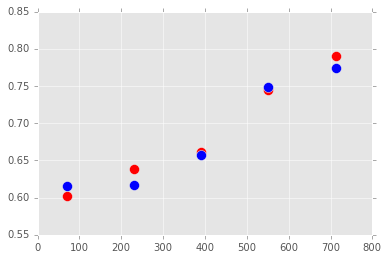

In [60]:
train_sizes, train_scores, valid_scores = learning_curve(svm.SVC(kernel="rbf", C = 1, gamma = 0.001), X, y, cv=5)

train_scores = np.average(train_scores, axis = 1)
valid_scores = np.average(valid_scores, axis = 1)

plt.scatter(train_sizes,train_scores, s=100, c='r')
plt.scatter(train_sizes,valid_scores, s=100, c='b')
plt.show()

In [104]:
def get_prediction_new(X,y):
    num_folds = 10

    kfold = KFold(n_splits=num_folds)
    # create the sub models
    estimators = []
    model1 = LogisticRegressionCV()
    estimators.append(('logistic', model1))
    
    model3 = svm.SVC(C=1, gamma=0.001)
    estimators.append(('svm rbf', model3))
    model4 = BaggingClassifier(svm.SVC(kernel='poly',C=2))
    estimators.append(('svm poly', model4))
    
    
    forest = RandomForestClassifier(n_estimators=100, max_features='sqrt', n_jobs = -1)
    estimators.append((('forest'),forest))
#     clf = BaggingClassifier(neighbors.KNeighborsClassifier(n_jobs=-1))
#     estimators.append(('KNN',clf))
    # create the ensemble model
    ensemble = VotingClassifier(estimators)
#     results = cross_val_score(ensemble, X, y, cv=kfold)
#     print(results.mean())

    return ensemble

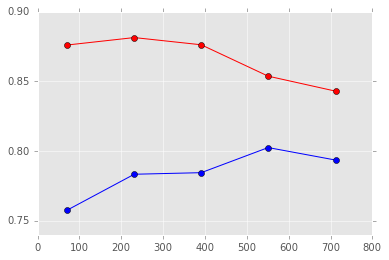

In [105]:
train_sizes, train_scores, valid_scores = learning_curve(get_prediction_new(X,y), X, y, cv=5)

train_scores = np.average(train_scores, axis = 1)
valid_scores = np.average(valid_scores, axis = 1)


plt.plot(train_sizes,train_scores, c='r',  marker='o',)
plt.plot(train_sizes,valid_scores, c='b',  marker='o',)
plt.show()

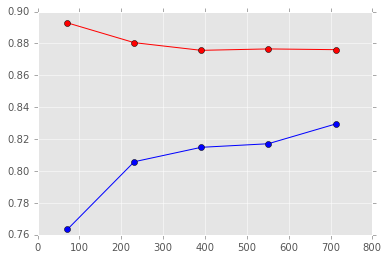

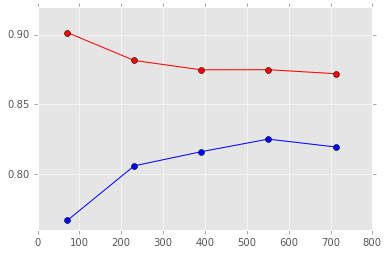

In [100]:
train_sizes, train_scores, valid_scores = learning_curve(get_prediction_new(X,y), X, y, cv=5)

train_scores = np.average(train_scores, axis = 1)
valid_scores = np.average(valid_scores, axis = 1)


plt.plot(train_sizes,train_scores, c='r',  marker='o',)
plt.plot(train_sizes,valid_scores, c='b',  marker='o',)t
plt.show()